In [10]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter


In [11]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=10)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="K.A.")
parser.add_argument("--Mach", type=float, default=0.05)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach= args["Mach"]


ICH FUNKTIONIERE MIT PULLEN


In [12]:
print(Precision)
lattice = lt.Lattice(lt.D3Q27, device = "cpu", dtype=torch.float32 if Precision == "Single" else torch.float64)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))
tensor=torch.tensor(1)
print(tensor.dtype)

# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)

print(flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


K.A.
11026.57790843584
torch.int64
0.5011026577908436
torch.float64
torch.float64


In [13]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/1)
interval_out=int((flow.units.convert_time_to_lu(tmax))/100)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_TGV(lattice, flow)
Energyspectrum= lt.EnergySpectrum(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2= lt.ObservableReporter(Dissipation_TGV, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
reporter3=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
simulation.reporters.append(reporter3)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_TGV
steps     time     EnergySpectrum


In [14]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
#print("Performance in MLUPS:", mlups)


torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.

In [15]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
print(nmax,dt)
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
#dissipationEkin=np.array([energy[:,1],-1/(np.pi*2)**3*np.gradient(energy[:,2],energy[:,1])])

dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*0.5)**3])

dissipationEns=np.array([dissipation[:,1],1/(0.5*np.pi)**3*dissipation[:,3]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)

101 0.09975896503288198


[31.00627668 30.8204255  30.63479361 30.44964184 30.26450682 30.07852306
 29.89169712 29.70381657 29.51438123 29.32309452 29.12968645 28.93384245
 28.73525696 28.53364828 28.32872863 28.12024573 27.90794474 27.69160114
 27.47100384 27.24597621 27.01636215 26.78204127 26.54292385 26.29895404
 26.05011273 25.79641094 25.53789759 25.27464579 25.00676381 24.73437763
 24.45764281 24.17672682 23.89181943 23.60311803 23.31083492 23.01518743
 22.71640104 22.41470509 22.11033138 21.80351493 21.49448894 21.18348975
 20.87074994 20.55650549 20.24098857 19.92443523 19.60707955 19.28916027
 18.97091689 18.65259362 18.33443759 18.01669976 17.69963484 17.38349924
 17.06855213 16.75505136 16.44325509 16.13341672 15.82578638 15.52060622
 15.21811163 14.91852746 14.62206846 14.32893688 14.03932239 13.75340119
 13.47133534 13.19327295 12.91934716 12.64967737 12.38436802 12.12351032
 11.86718105 11.61544463 11.36835208 11.12594306 10.88824502 10.65527507
 10.42703972 10.20353624  9.98475277  9.77066914  9

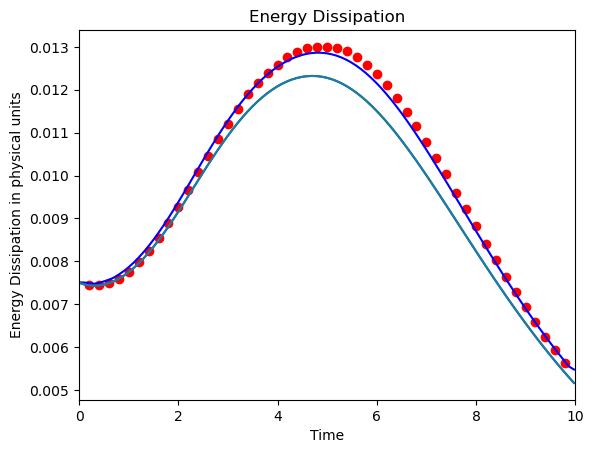

In [16]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(64*energy[:,2])

plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
#plt.plot(energy[:,1],energy[:,2]*64)
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()

In [17]:
energy=np.array(simulation.reporters[2].out)
print(energy)

[[0.00000000e+00 0.00000000e+00 6.49022683e-02 ... 1.87160594e-03
  1.40240663e-04 1.13755632e-05]
 [1.10000000e+02 9.97589650e-02 6.44769125e-02 ... 1.86050930e-03
  1.39258902e-04 1.12945375e-05]
 [2.20000000e+02 1.99517930e-01 6.39823831e-02 ... 1.84966023e-03
  1.38008482e-04 1.11891375e-05]
 ...
 [1.07800000e+04 9.77637857e+00 1.11761670e-02 ... 4.09892482e-04
  2.40654355e-05 1.67533637e-06]
 [1.08900000e+04 9.87613754e+00 1.09966011e-02 ... 4.00710844e-04
  2.35485570e-05 1.64131567e-06]
 [1.10000000e+04 9.97589650e+00 1.08213866e-02 ... 3.91770654e-04
  2.30447015e-05 1.60817081e-06]]


(101, 10)
[2.20000000e+02 1.99517930e-01 6.39823831e-02 3.45640150e-02
 9.78113888e-03 5.21928711e-03 4.12100156e-03 1.84966023e-03
 1.38008482e-04 1.11891375e-05]


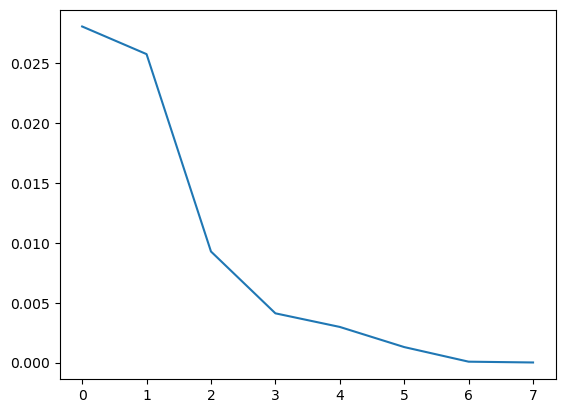

In [18]:
plt.plot(energy[50,2:])
print(energy.shape)
print(energy[2,:])